In [1]:
#Khai báo các thư viện 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model # type: ignore

#Các lớp để xây dựng mô hình
from keras.models import Sequential #Đầu vào 
from keras.layers import LSTM #Học phụ thuộc
from keras.layers import Dropout
from keras.layers import Dense

#Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #Đo phần trăm sai số tuyệt đối trung bình   

In [2]:
#Đọc dữ liệu
df=pd.read_csv('Data_vinamilk.csv')

In [3]:
#Mô tả dữ liệu
#Định dạng cấu trúc thời gian cho cột ngày
df['Ngày']=pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [4]:
#Kích thước của dữ liệu
df.shape

(2505, 7)

In [5]:
df.head()

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất,KL,% Thay đổi
0,2023-07-21,"73,500.0","72,500.0","75,000.0","72,400.0",3.12M,1.10%
1,2023-07-20,"72,700.0","72,600.0","72,900.0","72,300.0",2.45M,0.14%
2,2023-07-19,"72,600.0","72,500.0","73,000.0","72,400.0",2.95M,0.28%
3,2023-07-18,"72,400.0","72,500.0","72,600.0","72,200.0",2.93M,0.14%
4,2023-07-17,"72,300.0","73,000.0","73,600.0","72,200.0",3.92M,-1.36%


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Ngày        2505 non-null   datetime64[ns]
 1   Đóng cửa    2505 non-null   object        
 2   Mở cửa      2505 non-null   object        
 3   Cao nhất    2505 non-null   object        
 4   Thấp nhất   2505 non-null   object        
 5   KL          2505 non-null   object        
 6   % Thay đổi  2505 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 137.1+ KB


In [7]:
df = df.drop(columns=['KL'])
df= df.drop(columns=['% Thay đổi'])
df.head()

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất
0,2023-07-21,"73,500.0","72,500.0","75,000.0","72,400.0"
1,2023-07-20,"72,700.0","72,600.0","72,900.0","72,300.0"
2,2023-07-19,"72,600.0","72,500.0","73,000.0","72,400.0"
3,2023-07-18,"72,400.0","72,500.0","72,600.0","72,200.0"
4,2023-07-17,"72,300.0","73,000.0","73,600.0","72,200.0"


In [8]:
columns_to_convert = ['Đóng cửa', 'Mở cửa', 'Cao nhất', 'Thấp nhất']

for column in columns_to_convert:
    # Chuyển cột về kiểu chuỗi nếu chưa phải là chuỗi
    df[column] = df[column].astype(str)
    
    # Loại bỏ các ký tự không phải là số và chuyển đổi về dạng float
    df[column] = df[column].str.replace(',', '').astype(float)

# Nếu muốn chuyển đổi từ float sang int (nếu giá trị là số nguyên)
# df[column] = df[column].astype(int)

# Kiểm tra lại kiểu dữ liệu của các cột
print(df.dtypes)
df.head()


Ngày         datetime64[ns]
Đóng cửa            float64
Mở cửa              float64
Cao nhất            float64
Thấp nhất           float64
dtype: object


,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất
0,2023-07-21,73500.0,72500.0,75000.0,72400.0
1,2023-07-20,72700.0,72600.0,72900.0,72300.0
2,2023-07-19,72600.0,72500.0,73000.0,72400.0
3,2023-07-18,72400.0,72500.0,72600.0,72200.0
4,2023-07-17,72300.0,73000.0,73600.0,72200.0


In [9]:
df.describe()

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất
count,2505,2505.000000,2505.000000,2505.000000,2505.000000
mean,2018-07-17 16:17:14.730539008,97278.602874,97281.440479,98197.064152,96413.803992
min,2013-07-10 00:00:00,61260.100000,61829.900000,63159.600000,61260.100000
25%,2016-01-13 00:00:00,79773.600000,79777.400000,80534.300000,79000.000000
50%,2018-07-19 00:00:00,96528.000000,96528.000000,97222.000000,95479.000000
75%,2021-01-14 00:00:00,106667.000000,106741.000000,107680.000000,105848.000000
max,2023-07-21 00:00:00,175578.000000,175333.000000,175742.000000,174189.000000
std,NaN,22579.624636,22552.425024,22776.579534,22329.447128


In [10]:
#4 tiền xử lý dữu liệu

In [11]:
#Lấy dữ liệu
#dùng giá đóng cửa trong quá khứ để dự đoán
df1=pd.DataFrame(data=df,columns=['Ngày','Đóng cửa'])
df1.index=df1.Ngày# Đặt này là để cột x nó chạy theo cột ngày hay trục hoành hiển thị theo cột này
df1.drop('Ngày', axis=1, inplace=True)
df1.head()


,Đóng cửa
Ngày,
2023-07-21,73500.0
2023-07-20,72700.0
2023-07-19,72600.0
2023-07-18,72400.0
2023-07-17,72300.0


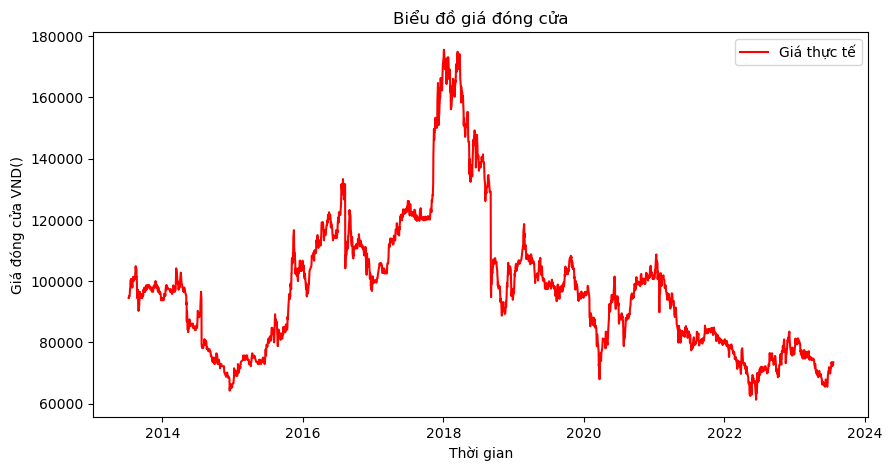

In [12]:
#Biểu đồ giá đóng cửa
plt.figure(figsize=(10,5))
plt.plot(df1['Đóng cửa'], label='Giá thực tế',color='red')
plt.title("Biểu đồ giá đóng cửa")
plt.xlabel('Thời gian')
plt.ylabel("Giá đóng cửa VND()")
plt.legend()#Chú thích
plt.show()

In [13]:
df1


,Đóng cửa
Ngày,
2023-07-21,73500.0
2023-07-20,72700.0
2023-07-19,72600.0
2023-07-18,72400.0
2023-07-17,72300.0
...,...
2013-07-16,96528.0
2013-07-15,95139.0
2013-07-12,95139.0


In [14]:
#Chia tập dữ liệu
data=df1.values
train_data=data[:1505]#1500 mẫu Đầu để huấn luyện
test_data=data[1505:]#Các giá trị còn lại bao bao gồm khoảng 1000 mẫu để dữ đoán

In [15]:
data

array([[73500.],
       [72700.],
       [72600.],
       ...,
       [95139.],
       [94444.],
       [94444.]])

In [16]:
#Chuẩn hóa dữ liệu điều chỉnh data coi giá trị nhỏ nhất nhất =0 lớn nhất =1 còn lại chạy từ 0->1
sc= MinMaxScaler(feature_range=(0,1))
sc_train=sc.fit_transform(data)

In [17]:
#Tạo vòng lặp các giá trị
#Mô hình sẽ sử dụng giá của 50 ngày liên tục làm cơ sở dự đoán cho giá của ngày tiếp theo
x_train,y_train=[],[]
for i in range(50,len(train_data)):
    x_train.append(sc_train[i-50:i,0])#dấu chia laf loc cắt từ i-50 đến i ví dụ i=50 [0:50]
    y_train.append(sc_train[i,0])

In [18]:
x_train # là 1 list danh sách các mảng mỗi mảng gồm 50 giá đóng cửa liên tục

[array([0.10706897, 0.10007094, 0.09919619, 0.09744668, 0.09657193,
        0.10531946, 0.10356996, 0.10706897, 0.1009457 , 0.09482242,
        0.08432538, 0.08082636, 0.07470309, 0.08170112, 0.08257587,
        0.08520013, 0.09307291, 0.08170112, 0.08082636, 0.08170112,
        0.06857981, 0.04933523, 0.04408671, 0.03708868, 0.03971294,
        0.0423372 , 0.04408671, 0.05108474, 0.05545851, 0.05808277,
        0.03971294, 0.03708868, 0.04321196, 0.04496146, 0.04583622,
        0.04058769, 0.0423372 , 0.0423372 , 0.04583622, 0.05108474,
        0.05108474, 0.05108474, 0.04408671, 0.05020998, 0.06070703,
        0.06420604, 0.06945456, 0.06770506, 0.07382833, 0.06770506]),
 array([0.10007094, 0.09919619, 0.09744668, 0.09657193, 0.10531946,
        0.10356996, 0.10706897, 0.1009457 , 0.09482242, 0.08432538,
        0.08082636, 0.07470309, 0.08170112, 0.08257587, 0.08520013,
        0.09307291, 0.08170112, 0.08082636, 0.08170112, 0.06857981,
        0.04933523, 0.04408671, 0.03708868, 0.

In [19]:
y_train # 1 danh sách giá đóng cửa của ngày hôm sau tương ứng với mỗi mảng của x_train

[0.07295357944818792,
 0.07645259403820404,
 0.08082636227572415,
 0.08257586957073215,
 0.07995160862822004,
 0.0659555502681557,
 0.06420604297314769,
 0.07645259403820404,
 0.07207882580068392,
 0.08520013051324427,
 0.07557784039069992,
 0.08082636227572415,
 0.08432537686574015,
 0.09307291334078038,
 0.09394766698828438,
 0.10269520346332461,
 0.09132340604577238,
 0.10094569616831661,
 0.10706897170084473,
 0.11406700088087696,
 0.11494175452838096,
 0.11494175452838096,
 0.11756601547089307,
 0.11406700088087696,
 0.11581650817588496,
 0.11319224723337296,
 0.11494175452838096,
 0.11494175452838096,
 0.12019027641340507,
 0.11931552276590107,
 0.11494175452838096,
 0.11669126182338896,
 0.12019027641340507,
 0.12281453735591719,
 0.11494175452838096,
 0.11494175452838096,
 0.11406700088087696,
 0.11581650817588496,
 0.13243682747846142,
 0.13856010301098953,
 0.13418633477346942,
 0.13681059571598153,
 0.13681059571598153,
 0.13331158112596542,
 0.13331158112596542,
 0.12718830

In [20]:
# Việc chuyển đổi dữ liệu thành mảng 1 chiều hoặc 3 chiều (như trong trường hợp này) thường là một bước chuẩn bị dữ liệu để phù hợp với yêu cầu đầu vào của các mô hình học sâu, đặc biệt là trong các mạng nơ-ron hồi tiếp (RNN) hoặc mạng nơ-ron tích chập (CNN). Dưới đây là lý do tại sao bạn cần phải chuyển dữ liệu thành dạng mảng 1 chiều hoặc 3 chiều:

# ### 1. **Yêu cầu của Mô Hình**
# Các mô hình học sâu, như RNN, LSTM, và GRU, thường yêu cầu dữ liệu đầu vào có dạng 3 chiều:

# - **Dữ liệu đầu vào**: `(số lượng mẫu, số lượng bước thời gian, số lượng đặc trưng)`

# Trong đó:
# - **Số lượng mẫu**: Số lượng bản ghi hoặc các mẫu dữ liệu.
# - **Số lượng bước thời gian**: Số lượng giai đoạn hoặc thời điểm trong chuỗi dữ liệu (thường là số lượng giá trị liên tiếp trong chuỗi thời gian).
# - **Số lượng đặc trưng**: Số lượng đặc trưng hoặc tính năng trong mỗi bước thời gian (ví dụ: số lượng thuộc tính đo lường trong mỗi thời điểm).

# ### 2. **Chuyển đổi Dữ Liệu**
# - **`x_train`**: Bạn có thể có dữ liệu đầu vào với dạng `(số lượng mẫu, số lượng đặc trưng)`. Để phù hợp với các mô hình như RNN, bạn cần chuyển đổi dữ liệu này thành dạng `(số lượng mẫu, số lượng bước thời gian, số lượng đặc trưng)`. Trong trường hợp này, bạn đã chọn số lượng bước thời gian là 1, do đó bạn cần chuyển đổi dữ liệu thành dạng `(số lượng mẫu, số lượng đặc trưng, 1)`.

# - **`y_train`**: Thường chỉ cần 1 chiều với dạng `(số lượng mẫu, 1)` cho các bài toán hồi quy hoặc phân loại.

# ### Ví dụ

# Giả sử bạn có dữ liệu `x_train` với dạng `(1000, 10)`, trong đó:
# - 1000 là số lượng mẫu.
# - 10 là số lượng đặc trưng trong mỗi mẫu.

# Nếu bạn muốn sử dụng mô hình RNN, bạn cần chuyển đổi dữ liệu thành dạng `(1000, 1, 10)`, trong đó:
# - 1000 là số lượng mẫu.
# - 1 là số bước thời gian (vì bạn chỉ có 1 bước thời gian trong mỗi mẫu).
# - 10 là số lượng đặc trưng.

# Câu lệnh chuyển đổi của bạn:

# ```python
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# ```

# ### Tóm lại

# Chuyển đổi dữ liệu thành dạng mảng 1 chiều hoặc 3 chiều là để đảm bảo rằng dữ liệu đầu vào phù hợp với định dạng yêu cầu của mô hình học sâu. Điều này giúp mô hình hiểu và xử lý dữ liệu đúng cách, từ đó cải thiện hiệu suất và khả năng dự đoán.

In [21]:
#Xếp dữ liệu thành 1 mảng để đưa vào mô hình
x_train = np.array(x_train)
y_train = np.array(y_train)
#Xếp dữ liệu thành mảng 1 chiều
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train=np.reshape(y_train,(y_train.shape[0], 1))

In [22]:
#5 Huấn luyện mô hình

In [23]:
#Xây dựng mô hình
#Mô hình gồm 5 lớp 1 lớp đầu vào input 2 lớp LSTM 1 lớp Dropout 1 lớp output
model = Sequential()#Tạo lớp mạng cho dữ liệu đầu vào
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))#Kết nối với đầu vào nên mô tả thông tin đầu vào = input shape
model.add(LSTM(units=64))
model.add(Dropout(0.5))# Giúp bỏ qua 1 số đơn vị trong quá trình huấn luyện 1 cách ngẫu nhiên tránh cho mô hình học tủ
model.add(Dense(1))# Lớp output Dense với đầu ra 1 chiều để dự đoán cho 1 giá trị
model.compile(loss='mean_absolute_error',optimizer='adam')# Hàm sai số loss sẽ đo sai số tuyệt đối trung bình , Trình tối ưu hóa adam giúp tối ưu hóa quá trình học

In [24]:
# Sử dụng hàm ModelCheckpoint để tìm ra model được huấn luyện tốt nhất thêm vào save_model
#Với tham số quan sát monitor là hàm sai số tuyệt đối trung bình loss( bên trên loss='mean_absolute_error')
#save_best_only=True mô hình sau khi huấn luyện chỉ lưu lại 1 mô hình huấn luyện tốt nhất
#tiến hành huấn luyện cho x_train và y_train với 100 lần lặp, và callback cho ModelCheckpoint để ModelCheckpoint có thể thực hiện sau mỗi 1 lần huấn luyện
#Nếu sai số của mô hình huấn luyện sau nhỏ hơn các lần huấn luyện trước , mô hình huấn luyện sau sẽ đc lưu lại sẽ được lưu lại. nếu sai số lớn hơn mô hình trc đó sẽ tự động bỏ qua

In [25]:
#Huấn luyện mô hình
save_model="save_model.hdf5"#Mô hình sau khi huấn luyện được lưu lại dưới dạng file save_model.hdf5
best_model=ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')# Sử dụng hàm ModelCheckpoint để tìm ra model được huấn luyện tốt nhất thêm vào save_model
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.09175, saving model to save_model.hdf5
30/30 - 11s - loss: 0.0917 - 11s/epoch - 380ms/step
Epoch 2/100

Epoch 2: loss improved from 0.09175 to 0.04733, saving model to save_model.hdf5
30/30 - 5s - loss: 0.0473 - 5s/epoch - 164ms/step
Epoch 3/100

Epoch 3: loss improved from 0.04733 to 0.04590, saving model to save_model.hdf5
30/30 - 5s - loss: 0.0459 - 5s/epoch - 178ms/step
Epoch 4/100

Epoch 4: loss improved from 0.04590 to 0.04272, saving model to save_model.hdf5
30/30 - 5s - loss: 0.0427 - 5s/epoch - 155ms/step
Epoch 5/100

Epoch 5: loss did not improve from 0.04272
30/30 - 5s - loss: 0.0455 - 5s/epoch - 158ms/step
Epoch 6/100

Epoch 6: loss improved from 0.04272 to 0.04262, saving model to save_model.hdf5
30/30 - 5s - loss: 0.0426 - 5s/epoch - 175ms/step
Epoch 7/100

Epoch 7: loss improved from 0.04262 to 0.04072, saving model to save_model.hdf5
30/30 - 5s - loss: 0.0407 - 5s/epoch - 158ms/step
Epoch 8/100

Epoch 8: loss did not imp

In [26]:
#Dữ liệu train
#y_train= Giá thực
#y_train_predict= Giá dự đoán
y_train=sc.inverse_transform(y_train)# Giá thực
final_model=load_model('save_model.hdf5')
y_train_predict=final_model.predict(x_train)
y_train_predict=sc.inverse_transform(y_train_predict)#Giá dự đoán
#inverse_transform là để điều chỉnh dữ liệu về định dạng giá trị gốc do dữ liệu đang đc chuẩn hóa từ 0->1

46/46 [==============================] - 4s 56ms/step


In [27]:
#6 sử dụng mô hình

In [28]:
#Xử lý dữ liệu trong tập test
test=df1[len(train_data)-50:].values
test=test.reshape(-1,1)
sc_test=sc.transform(test)
x_test=[]
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i-50:i,0])
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#Dữ liệu test
y_test=data[1505:]# Giá thực
y_test_predict=final_model.predict(x_test)
y_test_predict=sc.inverse_transform(y_test_predict) #Giá dự đoán

32/32 [==============================] - 2s 52ms/step


C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_30428\1406867615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_1['Dự đoán']=y_train_predict #Thêm dữ liệu
C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_30428\1406867615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_1['Dự đoán']=y_test_predict # Thêm dữ liệu


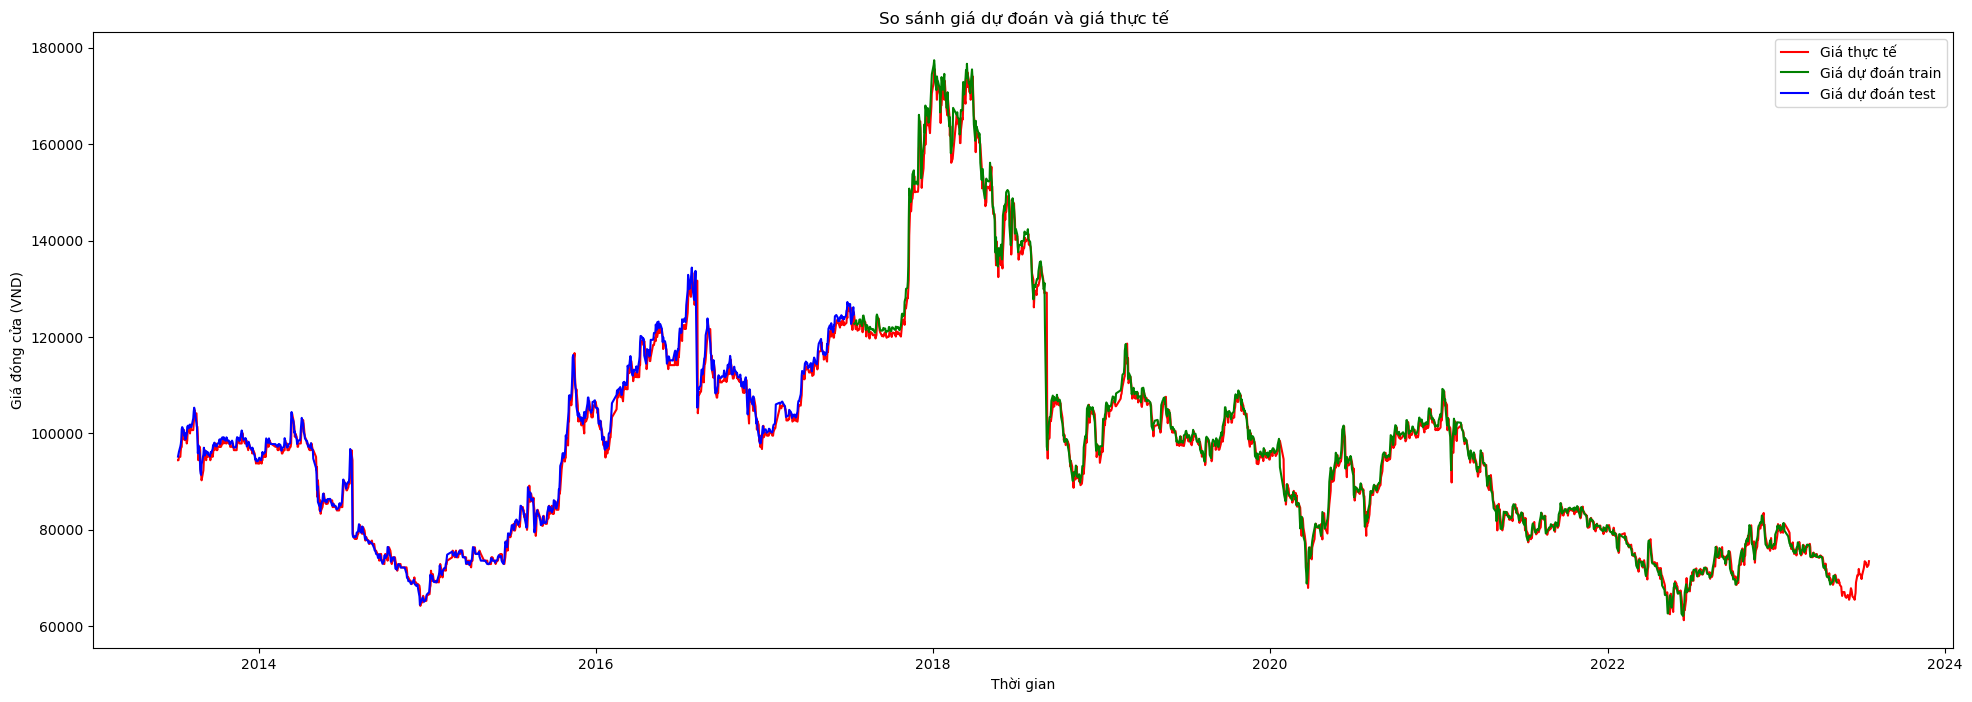

In [29]:
#7 Dùng biểu đồ để xem xét độ chính xác của mô hình
train_data_1=df1[50:1505]
test_data_1=df1[1505:]
plt.figure(figsize=(24,8))
plt.plot(df1,label="Giá thực tế",color='red')# Đường giá thực tế
train_data_1['Dự đoán']=y_train_predict #Thêm dữ liệu
plt.plot(train_data_1['Dự đoán'],label='Giá dự đoán train',color='green')# Đường giá dự báo trên tập train
test_data_1['Dự đoán']=y_test_predict # Thêm dữ liệu
plt.plot(test_data_1['Dự đoán'],label='Giá dự đoán test', color='blue')# Đường giá dự báo trên tập test
plt.title("So sánh giá dự đoán và giá thực tế") #Tên biểu đồ
plt.xlabel('Thời gian')# Đặt tên hàm x trục hoành
plt.ylabel('Giá đóng cửa (VND)')
plt.legend()# Chú giải biểu đồ
plt.show()

In [30]:
# Phù hợp train
print("Độ phù hợp tập train: ",r2_score(y_train,y_train_predict))
print("Sai số tuyệt đối trung bình tập train: ", mean_absolute_error(y_train,y_train_predict))
print("Phần trăm sai số tuyệt đối trung bình tập train: ", mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train:  0.9936758841268573
Sai số tuyệt đối trung bình tập train:  1334.6351830970789
Phần trăm sai số tuyệt đối trung bình tập train:  0.013265662775137453


In [31]:
train_data_1

,Đóng cửa,Dự đoán
Ngày,,
2023-05-12,69600.0,69129.796875
2023-05-11,70000.0,69306.015625
2023-05-10,70500.0,69708.398438
2023-05-09,70700.0,70205.890625
2023-05-08,70400.0,70532.398438
...,...,...
2017-07-20,121708.0,122483.054688
2017-07-19,122509.0,122756.000000
2017-07-18,121708.0,123477.234375


In [32]:
#Phù hợp tập test
print("Độ phù hợp tập test: ", r2_score(y_test, y_test_predict))
print("Sai số tuyệt đối trung bình tập test: ", mean_absolute_error(y_test, y_test_predict))
print("Phần trăm sai số tuyệt đối trung bình tập test: ", mean_absolute_percentage_error(y_test, y_test_predict))


Độ phù hợp tập test:  0.9873447734772036
Sai số tuyệt đối trung bình tập test:  1201.73732421875
Phần trăm sai số tuyệt đối trung bình tập test:  0.012182580414329515


In [33]:
test_data_1

,Đóng cửa,Dự đoán
Ngày,,
2017-07-13,125151.0,124713.632812
2017-07-12,124430.0,126175.148438
2017-07-11,122509.0,125784.726562
2017-07-10,121468.0,123997.164062
2017-07-07,123470.0,122718.703125
...,...,...
2013-07-16,96528.0,97789.992188
2013-07-15,95139.0,97290.437500
2013-07-12,95139.0,96194.382812
